In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import signal,stats
import pandas as pd
from typing import Dict
from collections import defaultdict
from ephysvibe.trials.spikes import firing_rate,sp_constants,plot_raster
from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.structures.bhv_data import BhvData
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.analysis import raw_ch,circular_stats
from ephysvibe.task import task_constants,def_task
import os 

In [2]:
def get_neurons_info(sp_samples:np.ndarray,fix_t:int,neuron_type:np.ndarray,target_codes:Dict,ipsi:np.ndarray,contra:np.ndarray,neuron_idx:np.ndarray=None)->pd.DataFrame:
    dt=1100
    if neuron_idx is None:
        neuron_idx = np.arange(0,len(neuron_type))
    codes =  target_codes.keys()
    neurons_info:Dict[str,list] = defaultdict(list)
    i_good,i_mua, n_type = 0,0,0
    for i_neuron,type_neuron in zip(neuron_idx,neuron_type):
        # check and count type of unit
        if type_neuron == 'good':
            i_good+=1
            n_type = i_good
        elif type_neuron == 'mua':
            i_mua+=1
            n_type = i_mua
        for code in codes: # iterate by code'
            psth_trial = None
            psth_bl = None
            trial_idx = np.array(target_codes[code]["trial_idx"])
            trial_idx = trial_idx[(sp_samples[trial_idx,i_neuron].sum(axis=1)>5*(1100+fix_t)/1000)]
            n_tr = len(trial_idx)
            if n_tr >2:
                psth_trial = np.max((sp_samples[trial_idx,i_neuron,fix_t:].sum(axis=0)/n_tr)*dt)
                psth_bl = np.max((sp_samples[trial_idx,i_neuron,:fix_t].sum(axis=0)/n_tr)*fix_t)
            if code in ipsi:
                laterality = 'ipsi'
            else:
                laterality='contra'
            neurons_info['code']+=[code]
            neurons_info['max_psth_trial']+=[psth_trial]
            neurons_info['max_psth_bl']+=[psth_bl]
            neurons_info['laterality']+=[laterality]
            neurons_info['cluster']+=[n_type]
            neurons_info['group']+=[type_neuron]
            neurons_info['array_position']+=[i_neuron]
    neurons_info = pd.DataFrame(neurons_info)
    return neurons_info

## Load data

In [4]:
# load data
filepath = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/lip/2023-03-07_10-14-11_Riesling_lip_e1_r1_sp.h5" #2023-02-27_10-50-03 2023-02-09_10-42-54 2023-03-21_10-40-02
s_path = os.path.normpath(filepath).split(os.sep)
data = SpikeData.from_python_hdf5(filepath)

In [5]:
# Select trials and create task frame
block = 2
trial_idx = np.where(np.logical_and(data.trial_error == 0, data.block == block))[0]
print("Number of clusters: %d" % len(data.clustersgroup))

Number of clusters: 8


In [6]:
# Define target codes 
position_codes= {
    # code: [[MonkeyLogic axis], [plot axis]]
    '127': [[10,0],[1,2],[0]],
    '126': [[7,7],[0,2],[45]],
    '125': [[0,10],[0,1],[90]],
    '124': [[-7,7],[0,0],[135]],
    '123': [[-10,0],[1,0],[180]],
    '122': [[-7,-7],[2,0],[225]],
    '121': [[0,-10],[2,1],[270]],
    '120': [[7,-7],[2,2],[315]],
}
# create dict with the trials having each code
target_codes = {}
for key in position_codes.keys():
    trials = []
    code_idx=[]
    for i_trial,code in zip(trial_idx, data.code_numbers[trial_idx]):
        idx=np.where(int(key) == code)[0]
        if len(idx)!=0:
            code_idx.append(idx[0])
            trials.append(i_trial)
    target_codes[key]={'code_idx':code_idx,'trial_idx':trials,'position_codes':position_codes[key][1],'angle_codes':position_codes[key][2][0]}

In [7]:
sp_samples = data.sp_samples
neuron_type = data.clustersgroup
code_samples = data.code_samples
code_numbers = data.code_numbers
sp_samples = data.sp_samples
align_event = task_constants.EVENTS_B2['target_on']
fix_t=200
shifts = code_samples[:,3]  
shifts = shifts[:,np.newaxis]
sp_shift = SpikeData.indep_roll(sp_samples, -(shifts-fix_t).astype(int), axis=2)[:,:,:1100+fix_t]

In [9]:
neuron_type = data.clustersgroup
ipsi = np.array(['124','123','122','121'])
contra = np.array(['120','127','126','125'])
neurons_info = get_neurons_info(sp_shift,fix_t,neuron_type,target_codes,ipsi,contra,neuron_idx=None)
neurons_info

,code,max_psth_trial,max_psth_bl,laterality,cluster,group,array_position
0,127,NaN,NaN,contra,1,good,0
1,126,NaN,NaN,contra,1,good,0
2,125,NaN,NaN,contra,1,good,0
3,124,NaN,NaN,ipsi,1,good,0
4,123,NaN,NaN,ipsi,1,good,0
...,...,...,...,...,...,...,...
59,124,366.666667,66.666667,ipsi,6,mua,7
60,123,314.285714,28.571429,ipsi,6,mua,7
61,122,244.444444,22.222222,ipsi,6,mua,7
62,121,440.000000,40.000000,ipsi,6,mua,7


### Neurons responding to the task
check if the the maximum fr is at least 2 times larger than the baseline

In [10]:
resp_neurons = neurons_info[neurons_info['max_psth_trial']>2*neurons_info['max_psth_bl']].reset_index(drop=True)

In [43]:
resp_neurons

,code,max_psth_trial,max_psth_bl,laterality,cluster,group,array_position
0,127,183.333333,33.333333,contra,1,mua,1
1,126,220.000000,40.000000,contra,1,mua,1
2,125,275.000000,33.333333,contra,1,mua,1
3,124,275.000000,25.000000,ipsi,1,mua,1
4,123,220.000000,40.000000,ipsi,1,mua,1
5,122,220.000000,40.000000,ipsi,1,mua,1
6,121,366.666667,33.333333,ipsi,1,mua,1
7,120,550.000000,50.000000,contra,1,mua,1
8,125,314.285714,57.142857,contra,3,mua,4
9,122,550.000000,50.000000,ipsi,3,mua,4


### RF
check locations where the fr is at least half of the max fr of the peak position

In [11]:
idx_max = resp_neurons.groupby(['array_position'])['max_psth_trial'].transform(max) == resp_neurons['max_psth_trial']
max_resp_neurons = resp_neurons[idx_max]

In [35]:
neu_rf =[]
for i_resp in resp_neurons['array_position'].unique():
    i_n_max = max_resp_neurons[max_resp_neurons['array_position']==i_resp]['max_psth_trial'].values[0]
    i_n = resp_neurons[resp_neurons['array_position']==i_resp]
    i_n = i_n[i_n['max_psth_trial'] >= i_n_max/2]
    neu_rf.append(i_n)
neu_rf=pd.concat(neu_rf)
neu_rf.reset_index(drop=True)

,code,max_psth_trial,max_psth_bl,laterality,cluster,group,array_position
0,125,275.000000,33.333333,contra,1,mua,1
1,124,275.000000,25.000000,ipsi,1,mua,1
2,121,366.666667,33.333333,ipsi,1,mua,1
3,120,550.000000,50.000000,contra,1,mua,1
4,125,314.285714,57.142857,contra,3,mua,4
5,122,550.000000,50.000000,ipsi,3,mua,4
6,127,366.666667,66.666667,contra,5,mua,6
7,126,733.333333,66.666667,contra,5,mua,6
8,123,366.666667,66.666667,ipsi,5,mua,6
9,122,440.000000,40.000000,ipsi,5,mua,6


### Visuomotor index

In [33]:
def get_vm_index(neu_rf,target_codes,code_samples,code_numbers,sp_samples,align_event,fix_t,dur_v,st_m,end_m):
    test_vm:Dict[str,list] = defaultdict(list)
    for _, row in neu_rf.iterrows():
        i_neuron = row['array_position']
        code = row['code']
        # event = row['event']   
        trial_idx = np.array(target_codes[code]["trial_idx"])# select trials with the same stimulus
        # select trials
        # shift = code_samples[trial_idx, np.where(code_numbers[trial_idx] == align_event)[1]] # moment when the target_on ocurrs in each trial
        shifts = code_samples[:,3]  
        shift_sp = SpikeData.indep_roll(sp_samples[:,i_neuron], -(shifts).astype(int), axis=1) # align trials with event onset
        shift_sp=shift_sp[:,:end_m]
        trial_idx = trial_idx[shift_sp[trial_idx,:end_m].sum(axis=1)>5*(end_m)/1000]
        n_tr = len(trial_idx)
        if n_tr >2:
            m_psth = (shift_sp[trial_idx,st_m:].sum(axis=0)/n_tr)*(end_m-st_m)
            v_psth = (shift_sp[trial_idx,:dur_v].sum(axis=0)/n_tr)*dur_v

        
            m_mean = m_psth.mean()
            v_mean = v_psth.mean()
            vm_index = (m_mean-v_mean)/(v_mean+m_mean)
            # save results
            test_vm['code']+=[code]
            test_vm['array_position']+=[i_neuron]
            test_vm['vm_index']+=[vm_index]

            test_vm['cluster']+=[row['cluster']]
            test_vm['group']+=[row['group']]
    test_vm = pd.DataFrame(test_vm)
    return test_vm

In [38]:
dur_v=200

In [37]:
test_vm=get_vm_index(neu_rf,target_codes,code_samples,code_numbers,sp_samples,align_event,fix_t,dur_v=200,st_m=600,end_m=1100)
test_vm

,code,array_position,vm_index,cluster,group
0,125,1,0.166667,1,mua
1,124,1,-0.162791,1,mua
2,121,1,-0.428571,1,mua
3,120,1,-0.227273,1,mua
4,125,4,0.200000,3,mua
5,122,4,0.555556,3,mua
6,123,6,-0.545455,5,mua
7,122,6,-0.317073,5,mua
8,121,6,-0.011494,5,mua
9,120,6,-0.518519,5,mua


In [41]:
def get_max_fr(target_codes,sp_samples,code_samples,code_numbers,i_n,kernel,win_size,dur_v,e_code_align,test_vm,fs_ds):
    fr_max_visual, fr_max_motor, fr_angle, fr_max_codes = [], [], [], []
    v_significant, m_significant = [], [] 
    for code in target_codes.keys():
        target_t_idx = target_codes[code][
            "trial_idx"
        ]  # select trials with the same stimulus
        trials_s_on = code_samples[target_t_idx,np.where(code_numbers[target_t_idx] == e_code_align)[1]]  
        shift_sp = SpikeData.indep_roll(sp_samples[target_t_idx, i_n],-(trials_s_on-win_size).astype(int),axis=1)  # align trials on event
        # select trials with at least one spike
        shift_sp = shift_sp[np.nansum(shift_sp, axis=1) > 0]
        mean_sp = np.nanmean(shift_sp,axis=0)  # mean of all trials
        conv = np.convolve(mean_sp, kernel, mode="same") * fs_ds
        fr_max_visual.append(np.nanmax(conv[win_size:win_size+dur_v]))
        fr_angle.append(target_codes[code]['angle_codes'])
        fr_max_motor.append(np.nanmax(conv[ win_size+800:win_size+1100]))
        fr_max_codes.append(np.nanmax(conv[win_size:win_size+1100]))
        if code in test_vm[(test_vm["array_position"] == i_n)&(test_vm["vm_index"]<0)]["code"].values:
            v_significant.append(True)
        else:
            v_significant.append(False)
        if code in test_vm[(test_vm["array_position"] == i_n)&(test_vm["vm_index"]>0)]["code"].values:
            m_significant.append(True)
        else:
            m_significant.append(False)
    return np.array(fr_max_visual),np.array(fr_max_motor),np.array(fr_angle),np.array(fr_max_codes),np.array(v_significant),np.array(m_significant)

/tmp/ipykernel_58313/2801503730.py:12: RuntimeWarning: Mean of empty slice
  mean_sp = np.nanmean(shift_sp,axis=0)  # mean of all trials
/tmp/ipykernel_58313/2801503730.py:14: RuntimeWarning: All-NaN slice encountered
  fr_max_visual.append(np.nanmax(conv[win_size:win_size+dur_v]))
/tmp/ipykernel_58313/2801503730.py:16: RuntimeWarning: All-NaN slice encountered
  fr_max_motor.append(np.nanmax(conv[ win_size+800:win_size+1100]))
/tmp/ipykernel_58313/2801503730.py:17: RuntimeWarning: All-NaN slice encountered
  fr_max_codes.append(np.nanmax(conv[win_size:win_size+1100]))


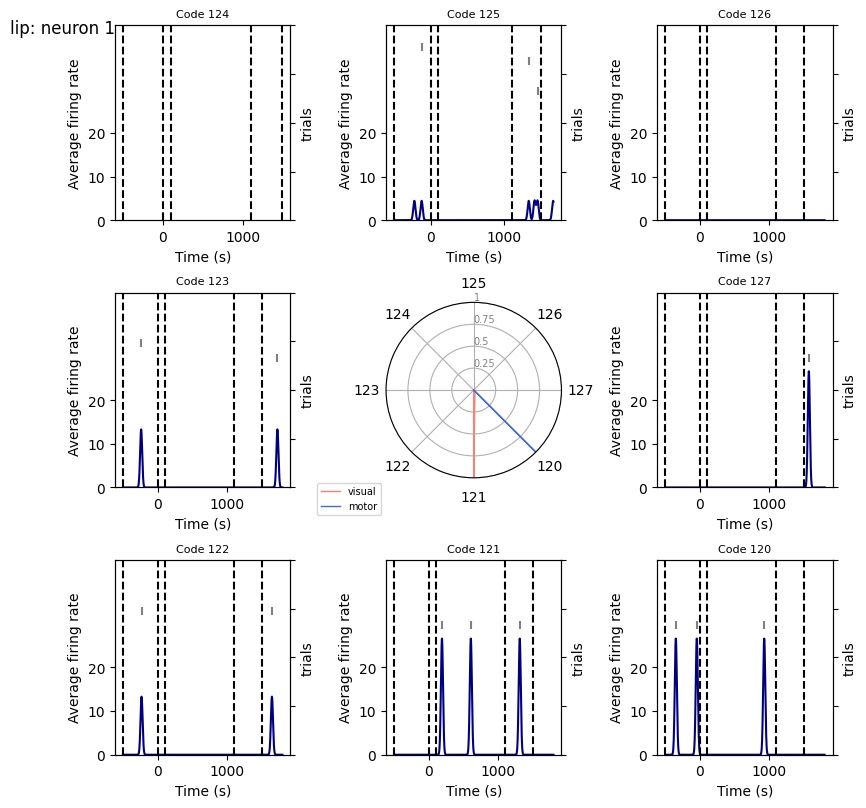

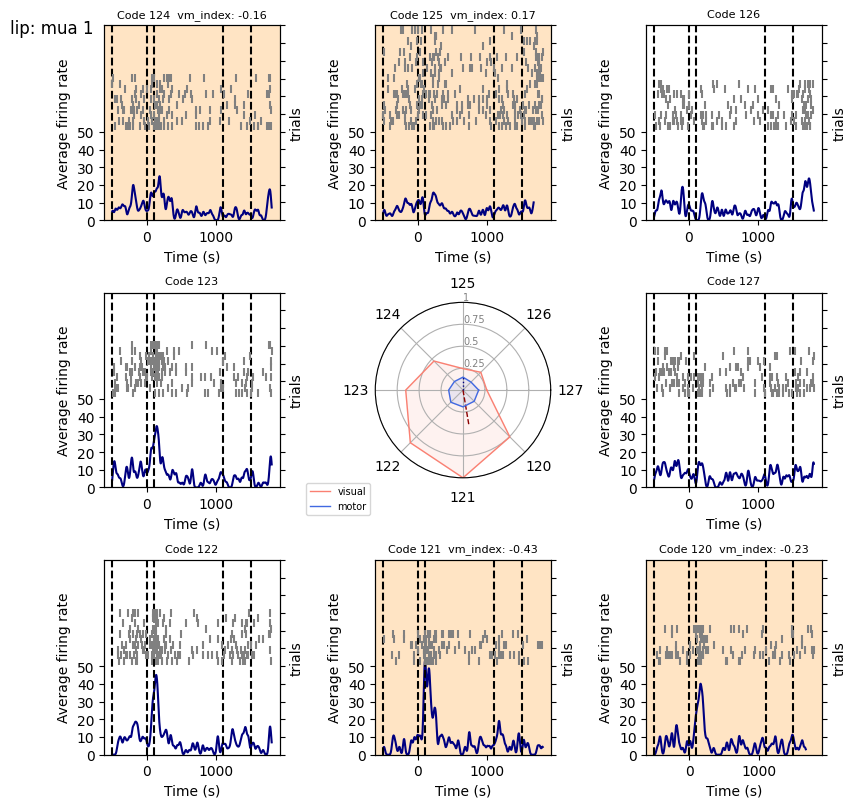

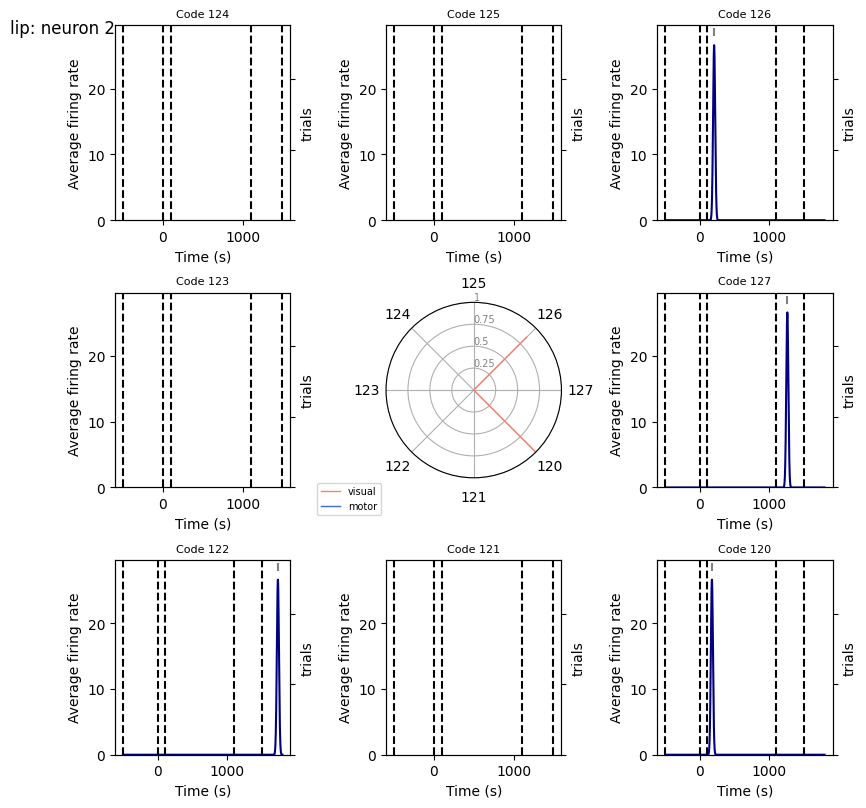

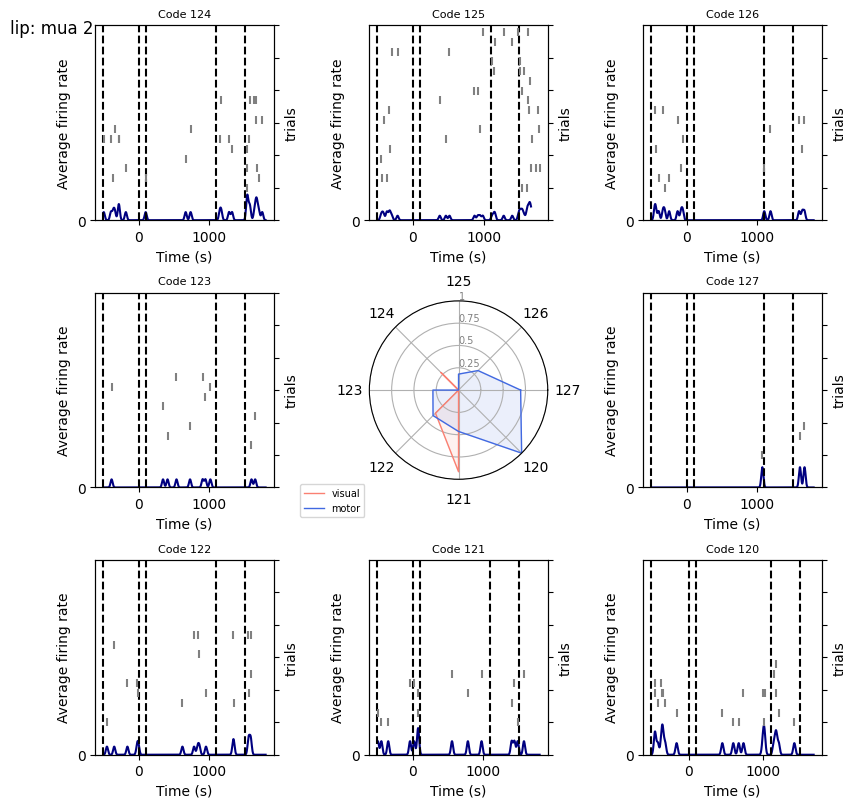

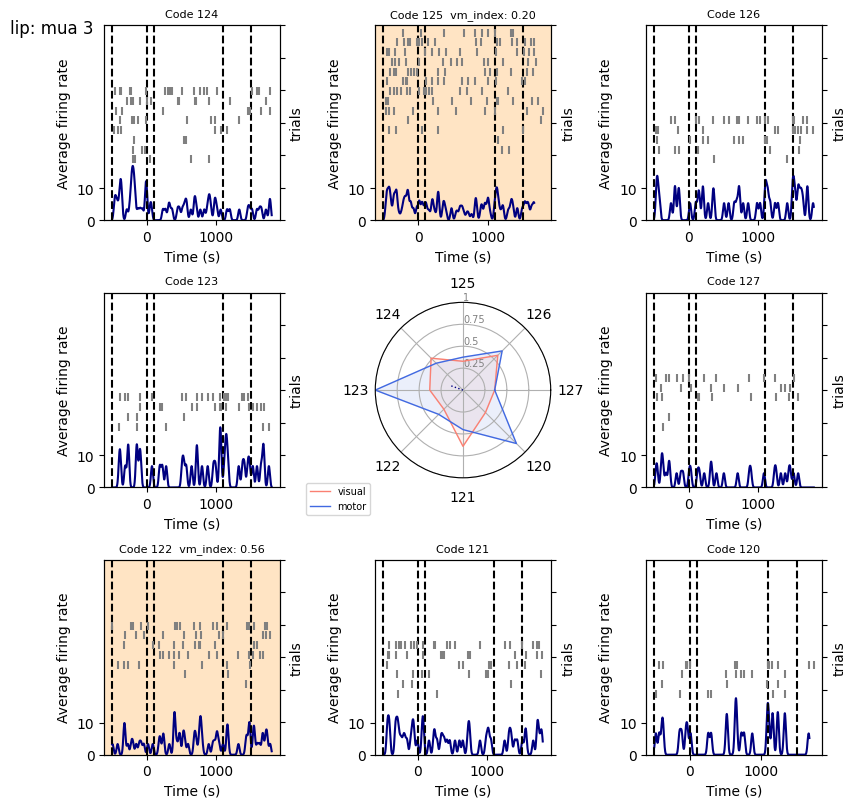

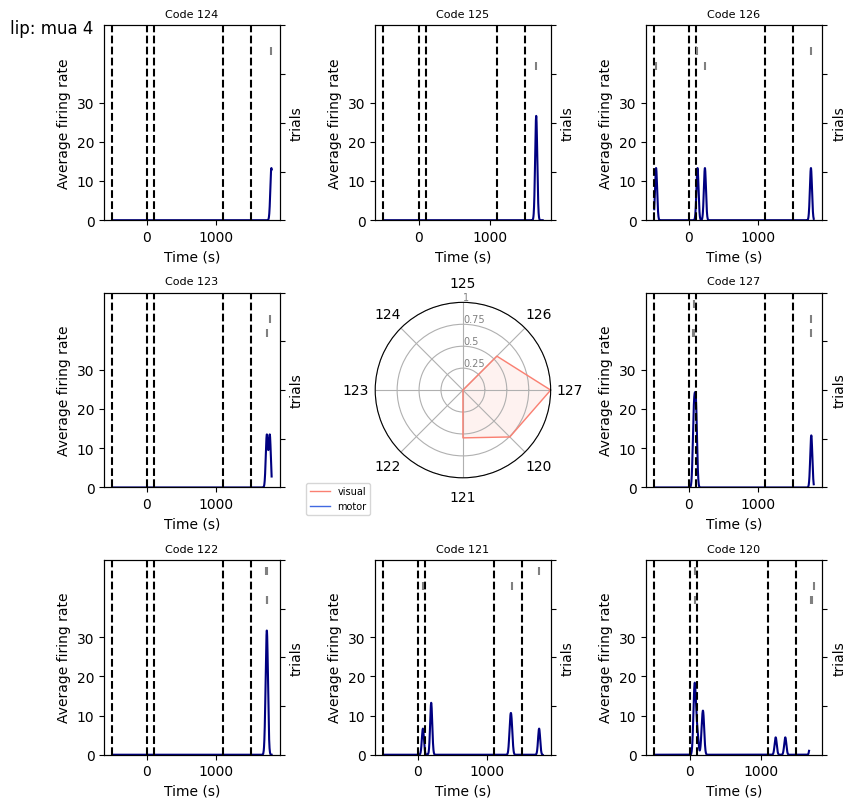

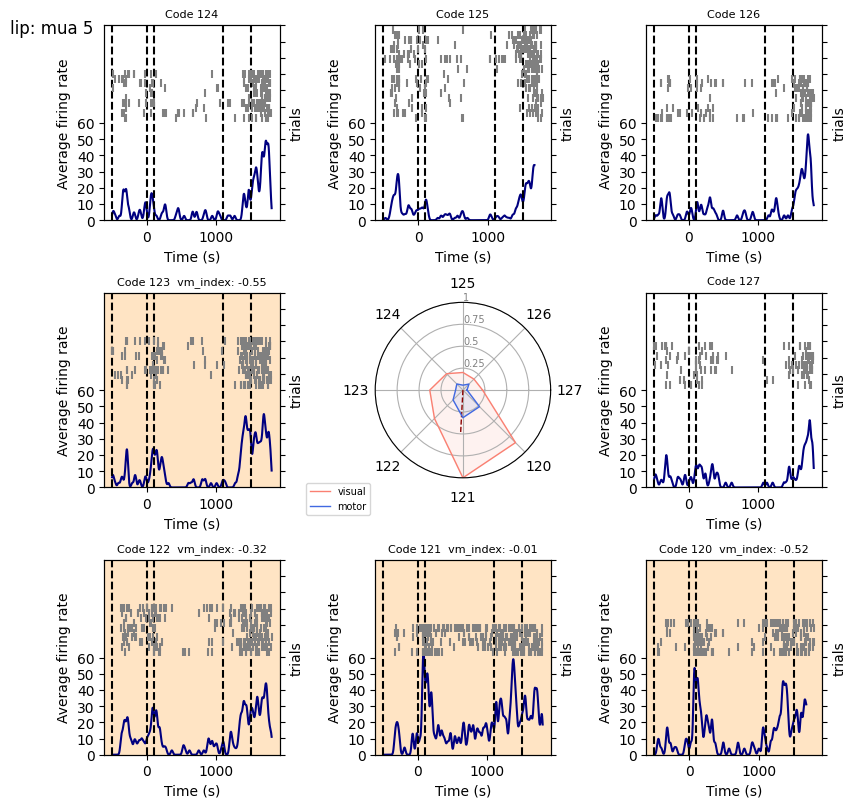

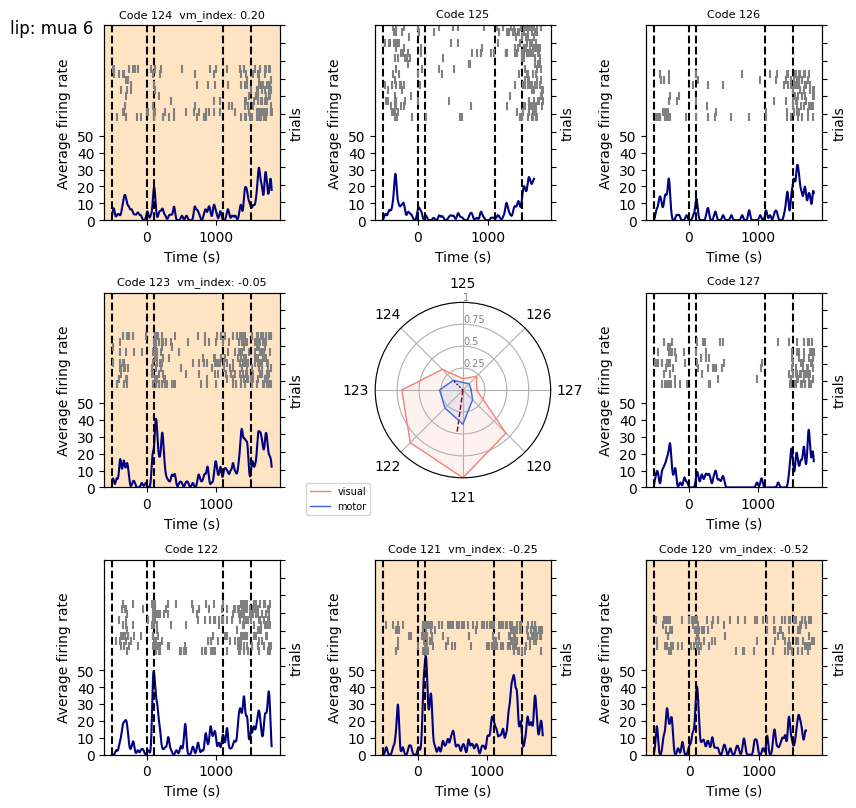

In [42]:
color={'visual':['salmon','darkred','--'],'motor':['royalblue','navy',':']}
# kernel parameters
t_before=500
fs_ds = config.FS / config.DOWNSAMPLE
kernel = firing_rate.define_kernel(
    sp_constants.W_SIZE, sp_constants.W_STD, fs=fs_ds
)
win_size = int(sp_constants.W_SIZE * fs_ds)
code_samples=data.code_samples
code_numbers=data.code_numbers
sp_samples=data.sp_samples
e_code_align = task_constants.EVENTS_B2['target_on']
# select only individual neurons
rf_coordinates:Dict[str,list] = defaultdict(list)
i_neuron, i_mua = 1, 1
for i_n, cluster in enumerate(data.clustersgroup): # iterate by units
    if cluster == "good":
        i_cluster = i_neuron
        i_neuron += 1
        cluster = "neuron"
    else:
        i_cluster = i_mua
        i_mua += 1
    fig, _ = plt.subplots(figsize=(8, 8), sharex=True, sharey=True) # define figure
    all_ax, all_ax2,all_max_conv,max_num_trials=plot_raster.plot_activity_location(target_codes,code_samples,code_numbers,sp_samples, i_n, e_code_align, t_before,fs_ds, kernel,test_vm)
    # ------------------ plot spider in the center 
    fr_max_visual,fr_max_motor,fr_angle,fr_max_codes,v_significant,m_significant = get_max_fr(target_codes,sp_samples,code_samples,code_numbers,i_n,kernel,win_size,dur_v,e_code_align,test_vm,fs_ds)
    codes_sig = np.logical_or(m_significant,v_significant)
    fr_code_max = max(fr_max_codes)
    vm_index=np.nan
    if np.any(~np.isnan(fr_max_codes[codes_sig])):

        idx_max_all = np.nanargmax(fr_max_codes[codes_sig])
        ang_max_all = fr_angle[codes_sig][idx_max_all]
        idx_code=np.where(pd.DataFrame(target_codes).iloc[3]==ang_max_all)[0][0]
        code = list(target_codes.keys())[idx_code]
        neu_test_vm = test_vm[test_vm["array_position"] == i_n]
        if code in neu_test_vm["code"].values:
            vm_index = neu_test_vm[neu_test_vm['code']==code]['vm_index'].values[0]  
    ax = plt.subplot2grid((3, 3), (1, 1), polar=True)
    fr_angle_rad=((np.array(fr_angle)*2 * np.pi )/360)
    fr_angle_rad = np.concatenate([fr_angle_rad,fr_angle_rad[:1]]) 
    
    for fr_max,event,significant in zip([fr_max_visual, fr_max_motor],['visual','motor'],[v_significant,m_significant]):
        norm_fr_max = np.array(fr_max)/fr_code_max
        # compute mean vector only visual or motor
        if np.any(significant):
            rad,ang = circular_stats.mean_vector(radius=norm_fr_max[significant], angle=fr_angle_rad[:-1][significant])
            idx_max = np.nanargmax(fr_max)
            fr_max_n = fr_max[idx_max]
            ang_max_n = fr_angle[idx_max]

        else:
            rad,ang = np.nan,np.nan
            fr_max_n=np.nan
            ang_max_n=np.nan
          
        # compute mean vector of all significant positions/codes
        if np.any(codes_sig):
            rad_all,ang_all = circular_stats.mean_vector(radius=fr_max_codes[codes_sig]/fr_code_max, angle=fr_angle_rad[:-1][codes_sig])
        else:
            rad_all,ang_all = np.nan,np.nan
        # plot max fr
        norm_fr_max = np.concatenate([norm_fr_max,norm_fr_max[:1]])
        ax.set_rlabel_position(90)
        plt.yticks([0.25,0.5,0.75,1], ['0.25','0.5','0.75','1'], color="grey", size=7)
        plt.ylim(0,1)
        plt.xticks(fr_angle_rad[:-1], target_codes.keys())
        ax.plot(fr_angle_rad, norm_fr_max, linewidth=1, linestyle='solid',color=color[event][0], label=event)
        ax.fill(fr_angle_rad, norm_fr_max, alpha=0.1,color=color[event][0])
        # plot mean vector              
        ax.plot([0,ang], [0,rad], linewidth=1, linestyle=color[event][2], color=color[event][1])
        plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 7})
        # add results to df
        rf_coordinates['array_position'] += [i_n] 
        rf_coordinates['event'] += [event]
        rf_coordinates['rad'] += [rad]
        rf_coordinates['ang'] += [ang]
        rf_coordinates['fr_max'] += [fr_max_n]
        rf_coordinates['ang_max'] += [ang_max_n]        
        rf_coordinates['rad_all'] += [rad_all]
        rf_coordinates['ang_all'] += [ang_all]
        rf_coordinates['depth'] += [data.clusterdepth[i_n]]
        rf_coordinates['date'] += [ang]
        rf_coordinates['vm_index'] += [vm_index]
    ## ------------------ end spider
    avg_events = [-500, 0, 100,1100,1500]
    num_trials = sp_samples.shape[0]
    for ax, ax2 in zip(all_ax, all_ax2):
        for ev in avg_events:
            ax.vlines(
                ev,
                0,
                all_max_conv + max_num_trials * 3,
                color="k",
                linestyles="dashed",
            )  # target_on
        ax.set_ylim(0, all_max_conv + max_num_trials * 3)
        ax.set_yticks(np.arange(0, all_max_conv, 10))
        ax2.set_ylim(-all_max_conv, max_num_trials)
        ax2.set_yticks(np.arange(-all_max_conv, max_num_trials * 3, 10))
        ax.set(xlabel="Time (s)", ylabel="Average firing rate")
        ax2.set(xlabel="Time (s)", ylabel="trials")
        plt.setp(ax2.get_yticklabels(), visible=False)
    fig.tight_layout(pad=0.4, h_pad=0.2, w_pad=0.2)
    fig.suptitle("%s: %s %d" % (s_path[-2], cluster, i_cluster), x=0)
rf_coordinates = pd.DataFrame(rf_coordinates)